In [1]:
import tensorflow as tf
import numpy as np
import cv2

model = tf.keras.models.load_model('/content/VGG19_Model_Bounded_Box_More_Process.h5')
last_conv_layer_name = 'block5_conv4'  # Or check using model.summary()
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

def preprocess_grayscale_image(image, target_size=(224, 224)):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, target_size)
    image = cv2.fastNlMeansDenoising(image, h=15)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    image = clahe.apply(image)
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    image = cv2.filter2D(blur, -1, sharpen_kernel)
    image = image.astype("float32") / 255.0
    image = np.stack((image,) * 3, axis=-1)  # to (224, 224, 3)
    return np.expand_dims(image, axis=0)     # to (1, 224, 224, 3)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def apply_heatmap_and_bbox(original_img, heatmap, threshold=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    binary_map = np.uint8(heatmap > threshold) * 255

    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_box = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return img_with_box

def predict_and_visualize(image):
    input_img = preprocess_grayscale_image(image)
    preds = model.predict(input_img)
    idx = np.argmax(preds[0])
    label = class_names[idx]
    confidence = float(preds[0][idx])

    # Get Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(input_img, model, last_conv_layer_name, idx)
    result_img = apply_heatmap_and_bbox(image, heatmap)

    return result_img, {label: confidence}

def apply_heatmap_overlay(original_img, heatmap, threshold=0.4, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    if len(original_img.shape) == 2:
        original_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    else:
        original_img_bgr = original_img.copy()

    overlayed_img = cv2.addWeighted(original_img_bgr, 1 - alpha, heatmap_color, alpha, 0)

    binary_map = np.uint8(heatmap_resized > threshold) * 255
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlayed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return overlayed_img


def visualize_gradcam_result(image, use_color=True, threshold=0.4):
    input_img = preprocess_grayscale_image(image)
    preds = model.predict(input_img)
    idx = np.argmax(preds[0])
    label = class_names[idx]
    confidence = float(preds[0][idx])

    heatmap = make_gradcam_heatmap(input_img, model, last_conv_layer_name, idx)

    if use_color:
        result_img = apply_heatmap_overlay(image, heatmap, threshold)
    else:
        result_img = apply_heatmap_and_bbox(image, heatmap, threshold)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"{label} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()

    return result_img, {label: confidence}



Color Grad-CAM with bounding box:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


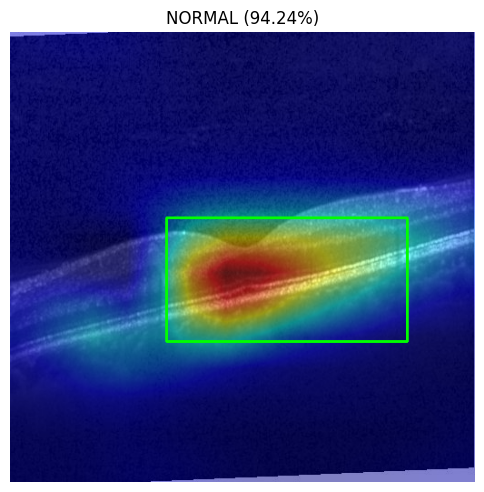


Grayscale + bounding box only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


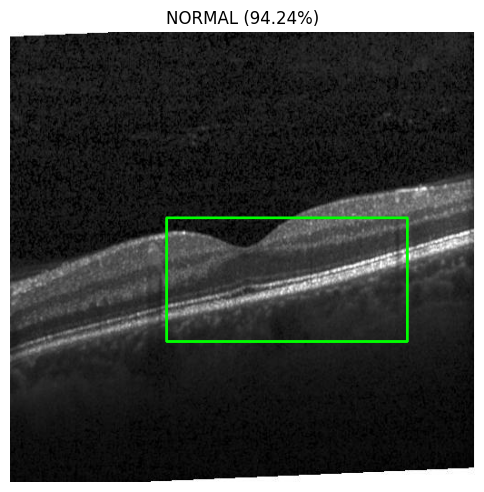

(array([[[255, 255, 255],
         [255, 255, 255],
         [254, 254, 254],
         ...,
         [  5,   5,   5],
         [ 11,  11,  11],
         [252, 252, 252]],
 
        [[252, 252, 252],
         [253, 253, 253],
         [255, 255, 255],
         ...,
         [ 23,  23,  23],
         [ 24,  24,  24],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 36,  36,  36],
         [ 31,  31,  31],
         [255, 255, 255]],
 
        ...,
 
        [[ 13,  13,  13],
         [ 12,  12,  12],
         [ 11,  11,  11],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 11,  11,  11],
         [  9,   9,   9],
         [ 10,  10,  10],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[  9,   9,   9],
         [  7,   7,   7],
         [  8,   8,   8],
         ...,
         [255, 255, 255],
  

In [2]:
import cv2
from matplotlib import pyplot as plt

# Load your image (grayscale)
image = cv2.imread('/content/NORMAL-12494-1.jpeg', cv2.IMREAD_GRAYSCALE)

# Grad-CAM with color
print("Color Grad-CAM with bounding box:")
visualize_gradcam_result(image, use_color=True)

# Grayscale + bounding box only
print("\nGrayscale + bounding box only:")
visualize_gradcam_result(image, use_color=False)


Color Grad-CAM with bounding box:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


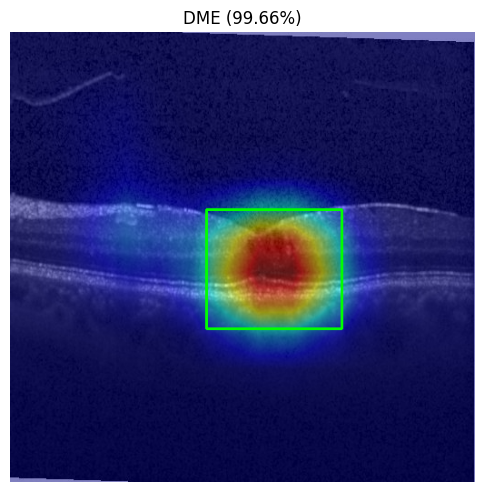


Grayscale + bounding box only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


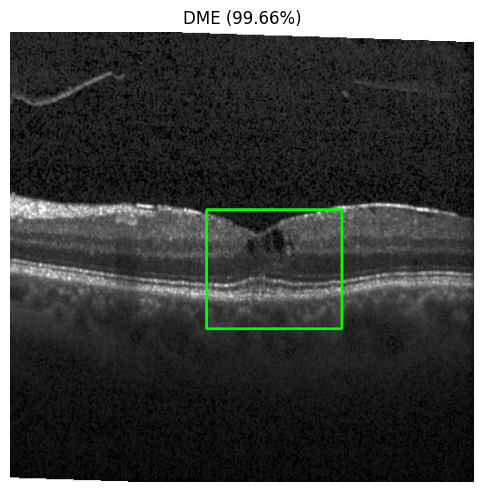

(array([[[ 37,  37,  37],
         [ 49,  49,  49],
         [ 48,  48,  48],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 49,  49,  49],
         [ 54,  54,  54],
         [ 45,  45,  45],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 52,  52,  52],
         [ 54,  54,  54],
         [ 44,  44,  44],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [  7,   7,   7],
         [  7,   7,   7],
         [252, 252, 252]],
 
        [[252, 252, 252],
         [252, 252, 252],
         [251, 251, 251],
         ...,
         [ 11,  11,  11],
         [ 10,  10,  10],
         [252, 252, 252]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 13,  13,  13],
  

In [3]:
import cv2
from matplotlib import pyplot as plt

# Load your image (grayscale)
image = cv2.imread('/content/DME-11053-1.jpeg', cv2.IMREAD_GRAYSCALE)

# Grad-CAM with color
print("Color Grad-CAM with bounding box:")
visualize_gradcam_result(image, use_color=True)

# Grayscale + bounding box only
print("\nGrayscale + bounding box only:")
visualize_gradcam_result(image, use_color=False)


Color Grad-CAM with bounding box:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


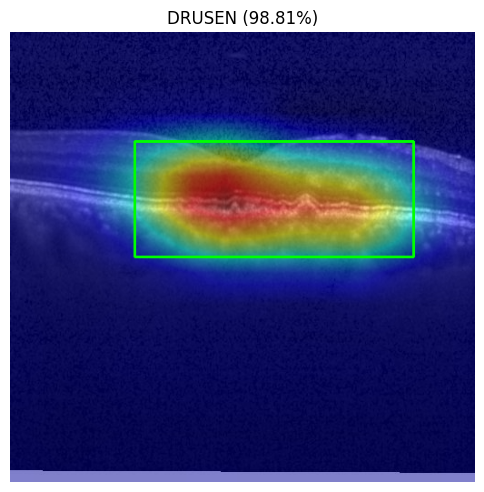


Grayscale + bounding box only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


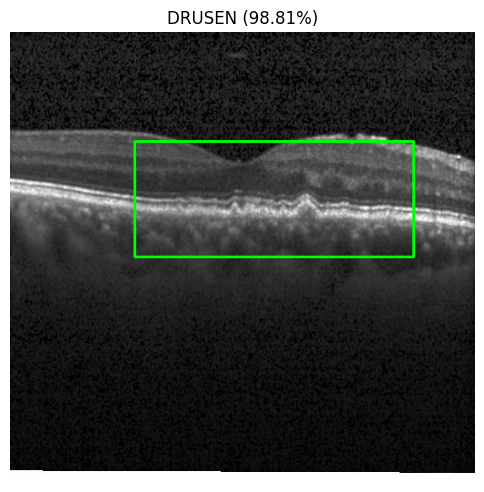

(array([[[  2,   2,   2],
         [ 18,  18,  18],
         [ 25,  25,  25],
         ...,
         [ 24,  24,  24],
         [ 16,  16,  16],
         [ 10,  10,  10]],
 
        [[ 26,  26,  26],
         [ 20,  20,  20],
         [  9,   9,   9],
         ...,
         [ 24,  24,  24],
         [ 22,  22,  22],
         [ 21,  21,  21]],
 
        [[ 22,  22,  22],
         [ 14,  14,  14],
         [  0,   0,   0],
         ...,
         [ 25,  25,  25],
         [ 31,  31,  31],
         [ 37,  37,  37]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [4]:
import cv2
from matplotlib import pyplot as plt

# Load your image (grayscale)
image = cv2.imread('/content/DRUSEN-228939-1.jpeg', cv2.IMREAD_GRAYSCALE)

# Grad-CAM with color
print("Color Grad-CAM with bounding box:")
visualize_gradcam_result(image, use_color=True)

# Grayscale + bounding box only
print("\nGrayscale + bounding box only:")
visualize_gradcam_result(image, use_color=False)


Color Grad-CAM with bounding box:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


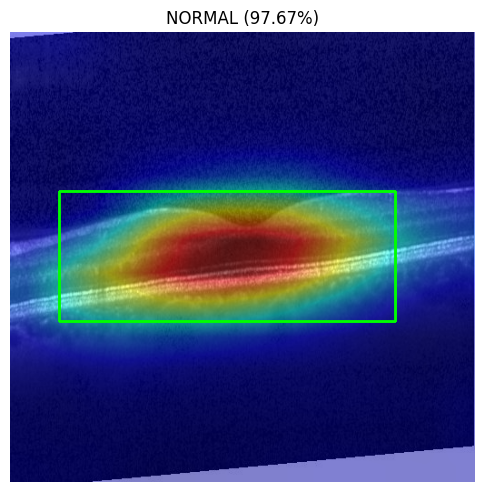


Grayscale + bounding box only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


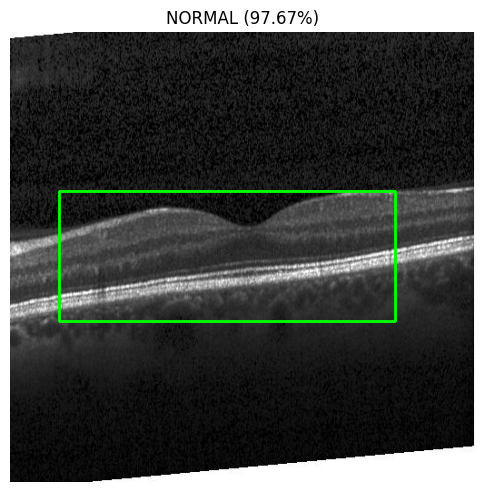

(array([[[251, 251, 251],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 27,  27,  27],
         [ 18,  18,  18],
         [253, 253, 253]],
 
        [[255, 255, 255],
         [247, 247, 247],
         [252, 252, 252],
         ...,
         [ 24,  24,  24],
         [ 26,  26,  26],
         [253, 253, 253]],
 
        [[255, 255, 255],
         [254, 254, 254],
         [255, 255, 255],
         ...,
         [ 24,  24,  24],
         [ 33,  33,  33],
         [255, 255, 255]],
 
        ...,
 
        [[ 15,  15,  15],
         [ 16,  16,  16],
         [  8,   8,   8],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 11,  11,  11],
         [ 13,  13,  13],
         [  7,   7,   7],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[  5,   5,   5],
         [ 11,  11,  11],
         [  6,   6,   6],
         ...,
         [255, 255, 255],
  

In [5]:
import cv2
from matplotlib import pyplot as plt

# Load your image (grayscale)
image = cv2.imread('/content/NORMAL-12494-2.jpeg', cv2.IMREAD_GRAYSCALE)

# Grad-CAM with color
print("Color Grad-CAM with bounding box:")
visualize_gradcam_result(image, use_color=True)

# Grayscale + bounding box only
print("\nGrayscale + bounding box only:")
visualize_gradcam_result(image, use_color=False)


In [7]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00


In [10]:
import gradio as gr

def gradcam_gradio_interface(image, use_color):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    result_img, prediction = visualize_gradcam_result(image, use_color=use_color)
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)  # 🔁 FIX HERE
    return result_img, prediction
gr.Interface(
    fn=gradcam_gradio_interface,
    inputs=[
        gr.Image(type="numpy", label="Upload Grayscale Retinal Image"),
        gr.Checkbox(label="Use Color Overlay Grad-CAM", value=True)
    ],
    outputs=[
        gr.Image(type="numpy", label="Grad-CAM Result"),
        gr.Label(label="Prediction")
    ],
    title="Retinal Disease Detection with Grad-CAM",
    description="Upload a grayscale retinal image to see Grad-CAM explanation using a VGG19 model."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://06a7d75f4794bc8f4f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
